# Preparing SDSS DR14 VACs


## Introduction

Working with the SDSS DR14 VAC files in preparation for loading into a database. There are four VACs currently targeted for loading into Data Lab:

1. [DR14Q](https://www.sdss.org/dr15/data_access/value-added-catalogs/?vac_id=the-sloan-digital-sky-survey-quasar-catalog-fourteenth-data-release)
2. [Firefly on SDSS/BOSS/eBOSS spectra](https://www.sdss.org/dr15/data_access/value-added-catalogs/?vac_id=firefly-stellar-population-models-of-sdss-and-eboss-galaxy-spectra)
3. [SPIDERS BH mass estimates](https://www.sdss.org/dr15/data_access/value-added-catalogs/?vac_id=optical-emission-line-properties-and-black-hole-mass-estimates-for-spiders-dr14-agn)
4. [Redmonster](https://www.sdss.org/dr15/data_access/value-added-catalogs/?vac_id=redshift-measurement-and-spectral-classification-catalog-with-redmonster)  This table may be deferred indefinitely.  Turns out there is not much support for this table.

All of these are conveniently stored as single FITS tables.  However, varying degrees of preprocessing may be needed.

Other resources:

* [SDSS CAS SQL definition files](https://trac.sdss.org/browser/repo/sdss/sas/trunk/sql)


## Setup

In [1]:
# Standard library
from io import BytesIO
import re
import csv
# matplotlib, etc.
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
from matplotlib.font_manager import fontManager, FontProperties
import numpy as np
from astropy.io import fits
from astropy.visualization import astropy_mpl_style
from astropy.io.votable import parse_single_table
from astropy.table import Column, Table
plt.style.use(astropy_mpl_style)
matplotlib.rcParams['figure.figsize'] = (10.0, 10.0)
# Data Lab
from dl import queryClient as qc, storeClient as sc
#
# Global constants.
#
release = 14
sas = 'sdss_dr{0:d}://'.format(release)
sdss_run2d = 26
boss_run2d = 'v5_10_0'
# assert matplotlib.rcParams['figure.figsize'] == (10.0, 10.0)

In [2]:
def inthist(foo, show=False):
    """Create a histogram of integer values.

    Parameters
    ----------
    foo : numpy.ndarray
        An array containing integers.
    show : bool, optional
        If ``True``, create a histogram and return the matplotlib.axes.Axes
        instance.

    Returns
    -------
    inthist : mixed
    """
    xmin = min(foo)
    xmax = max(foo)
    x = np.arange( xmin, xmax+1 )
    n = np.zeros( x.shape, dtype=x.dtype )
    for k in range(len(n)):
        n[k] = np.sum( foo == x[k] )
    if show:
        fig = plt.figure(dpi=100)
        ax = fig.add_subplot(111)
        b = ax.bar(x,n,align='center',width=0.5,color='w')
        ax.set_xlim(xmin-1, xmax+1)
        # ax.set_ylim(0, np.ceil(max(n)/10.0)*10.0)
        ax.set_ylim(0, 10**np.ceil(np.log10(max(n))))
        return ax
    else:
        return (n,x)

In [3]:
def sdss_specobjid(plate, fiber, mjd, run2d, line=None, index=None):
    """Convert SDSS spectrum identifiers into CAS-style specObjID.
    Bits are assigned in specObjID thus:
    ===== ========== =============================================================
    Bits  Name       Comment
    ===== ========== =============================================================
    50-63 Plate ID   14 bits
    38-49 Fiber ID   12 bits
    24-37 MJD        Date plate was observed minus 50000 (14 bits)
    10-23 run2d      Spectroscopic reduction version
    0-9   line/index 0 for use in SpecObj files see below for other uses (10 bits)
    ===== ========== =============================================================
    Parameters
    ----------
    plate, fiber, mjd : :class:`int` or array of int
        Plate, fiber ID, and MJD for a spectrum.  If arrays are
        passed, all must have the same length.  The MJD value must be
        greater than 50000.
    run2d : :class:`int`, :class:`str` or array of int or str
        The run2d value must be an integer or a string of the form 'vN_M_P'.
        If an array is passed, it must have the same length as the other
        inputs listed above.  If the string form is used, the values are
        restricted to :math:`5 \le N \le 6`, :math:`0 \le M \le 99`,
        :math:`0 \le P \le 99`.
    line : :class:`int`, optional
        A line index, only used for defining specObjID for SpecLine files.
        `line` and `index` cannot both be non-zero.
    index : :class:`int`, optional
        An index measure, only used for defining specObjID for SpecLineIndex
        files. `line` and `index` cannot both be non-zero.
    Returns
    -------
    :class:`numpy.ndarray` of :class:`numpy.uint64`
        The specObjIDs of the objects.
    Raises
    ------
    :exc:`ValueError`
        If the sizes of the arrays don't match or if the array values are
        out of bounds.
    Notes
    -----
    * On 32-bit systems, makes sure to explicitly declare all inputs as
      64-bit integers.
    * This function defines the SDSS-III/IV version of specObjID, used for
      SDSS DR8 and subsequent data releases.  It is not compatible with
      SDSS DR7 or earlier.
    * If the string form of `run2d` is used, the bits are assigned by
      the formula :math:`(N - 5) \\times 10000 + M \\times 100 + P`.
    Examples
    --------
    >>> from pydl.pydlutils.sdss import sdss_specobjid
    >>> print(sdss_specobjid(4055,408,55359,'v5_7_0'))
    [4565636362342690816]
    """
    if line is not None and index is not None:
        raise ValueError("line and index inputs cannot both be non-zero!")
    if isinstance(plate, int):
        plate = np.array([plate], dtype=np.uint64)
    if isinstance(fiber, int):
        fiber = np.array([fiber], dtype=np.uint64)
    if isinstance(mjd, int):
        mjd = np.array([mjd], dtype=np.uint64) - 50000
    if isinstance(run2d, str):
        try:
            run2d = np.array([int(run2d)], dtype=np.uint64)
        except ValueError:
            # Try a "vN_M_P" string.
            m = re.match(r'v(\d+)_(\d+)_(\d+)', run2d)
            if m is None:
                raise ValueError("Could not extract integer run2d value!")
            else:
                N, M, P = m.groups()
            run2d = np.array([(int(N) - 5)*10000 + int(M) * 100 + int(P)],
                             dtype=np.uint64)
    elif isinstance(run2d, int):
        run2d = np.array([run2d], dtype=np.uint64)
    if line is None:
        line = np.zeros(plate.shape, dtype=plate.dtype)
    else:
        if isinstance(line, int):
            line = np.array([line], dtype=np.uint64)
    if index is None:
        index = np.zeros(plate.shape, dtype=plate.dtype)
    else:
        if isinstance(index, int):
            index = np.array([index], dtype=np.uint64)
    #
    # Check that all inputs have the same shape.
    #
    if plate.shape != fiber.shape:
        raise ValueError("fiber.shape does not match plate.shape!")
    if plate.shape != mjd.shape:
        raise ValueError("mjd.shape does not match plate.shape!")
    if plate.shape != run2d.shape:
        raise ValueError("run2d.shape does not match plate.shape!")
    if plate.shape != line.shape:
        raise ValueError("line.shape does not match plate.shape!")
    if plate.shape != index.shape:
        raise ValueError("index.shape does not match plate.shape!")
    #
    # Check ranges of parameters
    #
    if ((plate < 0) | (plate >= 2**14)).any():
        raise ValueError("plate values are out-of-bounds!")
    if ((fiber < 0) | (fiber >= 2**12)).any():
        raise ValueError("fiber values are out-of-bounds!")
    if ((mjd < 0) | (mjd >= 2**14)).any():
        raise ValueError("MJD values are out-of-bounds!")
    if ((run2d < 0) | (run2d >= 2**14)).any():
        raise ValueError("MJD values are out-of-bounds!")
    if ((line < 0) | (line >= 2**10)).any():
        raise ValueError("line values are out-of-bounds!")
    if ((index < 0) | (index >= 2**10)).any():
        raise ValueError("index values are out-of-bounds!")
    #
    # Compute the specObjID
    #
    specObjID = ((plate << 50) |
                 (fiber << 38) |
                 (mjd << 24) |
                 (run2d << 10) |
                 (line | index))
    return specObjID

In [4]:
def unwrap_specobjid(specObjID, run2d_integer=False, specLineIndex=False):
    """Unwrap CAS-style specObjID into plate, fiber, mjd, run2d.
    See :func:`~pydl.pydlutils.sdss.sdss_specobjid` for details on how the
    bits within a specObjID are assigned.
    Parameters
    ----------
    specObjID : :class:`numpy.ndarray`
        An array containing 64-bit integers or strings.  If strings are passed,
        they will be converted to integers internally.
    run2d_integer : :class:`bool`, optional
        If ``True``, do *not* attempt to convert the encoded run2d values
        to a string of the form 'vN_M_P'.
    specLineIndex : :class:`bool`, optional
        If ``True`` interpret any low-order bits as being an 'index'
        rather than a 'line'.
    Returns
    -------
    :class:`numpy.recarray`
        A record array with the same length as `specObjID`, with the columns
        'plate', 'fiber', 'mjd', 'run2d', 'line'.
    Examples
    --------
    >>> from numpy import array, uint64
    >>> from pydl.pydlutils.sdss import unwrap_specobjid
    >>> unwrap_specobjid(array([4565636362342690816], dtype=uint64))
    rec.array([(4055, 408, 55359, 'v5_7_0', 0)],
              dtype=[('plate', '<i4'), ('fiber', '<i4'), ('mjd', '<i4'), ('run2d', '<U8'), ('line', '<i4')])
    """
    if (specObjID.dtype.type is np.string_ or
        specObjID.dtype.type is np.unicode_):
        tempobjid = specObjID.astype(np.uint64)
    elif specObjID.dtype.type is np.uint64:
        tempobjid = specObjID.copy()
    else:
        raise ValueError('Unrecognized type for specObjID!')
    run2d_dtype = 'U8'
    if run2d_integer:
        run2d_dtype = 'i4'
    line = 'line'
    if specLineIndex:
        line = 'index'
    unwrap = np.recarray(specObjID.shape,
                         dtype=[('plate', 'i4'), ('fiber', 'i4'),
                                ('mjd', 'i4'), ('run2d', run2d_dtype),
                                (line, 'i4')])
    unwrap.plate = np.bitwise_and(tempobjid >> 50, 2**14 - 1)
    unwrap.fiber = np.bitwise_and(tempobjid >> 38, 2**12 - 1)
    unwrap.mjd = np.bitwise_and(tempobjid >> 24, 2**14 - 1) + 50000
    run2d = np.bitwise_and(tempobjid >> 10, 2**14 - 1)
    if run2d_integer:
        unwrap.run2d = run2d
    else:
        N = ((run2d // 10000) + 5).tolist()
        M = ((run2d % 10000) // 100).tolist()
        P = (run2d % 100).tolist()
        unwrap.run2d = ['v{0:d}_{1:d}_{2:d}'.format(n, m, p)
                        for n, m, p in zip(N, M, P)]
    unwrap[line] = np.bitwise_and(tempobjid, 2**10 - 1)
    return unwrap

## DR14Q

### Overview

* [data model](https://data.sdss.org/datamodel/files/BOSS_QSO/DR14Q/DR14Q_v4_4.html)
* [Pâris et al. (2018)](https://arxiv.org/abs/1712.05029)

### Preprocessing Plan

* Compute `specObjID`; add `run2d` column.
* Delete photometric information.
* Move duplicate information to separate table.
* Coerce some matching flags to integer.
* Coerce floating point values (except `RA`, `DEC`) to 32-bit float.

### Known Problems

* The columns `GALEX_MATCHED`, `UKIDSS_MATCHED` are stored as float when they should be integers.  The also contain NaN values, and `GALEX_MATCHED` contains some values which are 2.  None of these cases are described in the DR14Q paper.  Only `FIRST_MATCHED` has valid values and is consistent with its description in the paper.
* The photometric id values, `RUN_NUMBER`, `COL_NUMBER`, are all nonsense values.  All identically zero in fact.
* The duplicate column contains extraneous zeroes, and not all duplicates are actually stored in the column.  See below for examples.  It would be much better if the duplicates were a separate table, mapping primary specObjID to duplicate specObjID.
* `TUNIT` columns should be blank when the value has no unit, instead of `-`.
* I would recommend checking that all units in the table conform to the FITS standard.  For example 'Vega' is a description of a unit, not a physical unit. Also, the `RASS_COUNTS` column has units counts/s, which is misleading, because the units are actually log(counts/s).  Exception: nanomaggies are not standard, but are OK.
* Column names, *e.g.* `FLUX_0.2_2.0keV` contain characters that could be interpreted as integers.
* Not all "primary" objects in DR14Q correspond to real objects in the specObjAll table.  And not all "duplicates" correspond to real objects either.  In these cases there are spectra that exist on disk, but are not now, and probably never will be added to CAS.  This makes it particularly difficult to cleanly join DR14Q to specObjAll.

In [5]:
qso_version = 'v4_4'
vopath = "{0}eboss/qso/DR{1:d}Q/DR{1:d}Q_{2}.fits".format(sas, release, qso_version)
with BytesIO(sc.get(vopath, mode='binary')) as q:
    with fits.open(q) as hdulist:
        dr14q = hdulist['DR14Q_v4_4'].data

### specObjID

Compute `specObjID` for the spectra.  Be careful, because there are some SEGUE spectra in the mix!

In [6]:
w = dr14q['SPECTRO'] == 'SDSS'
dr14q['PLATE'][w].max()

2974

In [7]:
w = dr14q['SPECTRO'] == 'BOSS'
dr14q['PLATE'][w].min() 

3586

In [8]:
run2d = np.array([boss_run2d.encode('utf-8')]*len(dr14q))
w = dr14q['SPECTRO'] == 'SDSS'
for p in np.unique(dr14q['PLATE'][w]):
    q = "SELECT run2d FROM sdss_dr{0:d}_new.platex WHERE plate = {1:d};".format(release, p)
    vot = qc.query(sql=q, fmt='votable', async=False)
    result = parse_single_table(BytesIO(vot.encode('utf-8')))
    ww = dr14q['PLATE'] == p
    # print(result.array['run2d'][0])
    run2d[ww] = result.array['run2d'][0]
run2d_lookup = dict(zip(dr14q['PLATE'], run2d))

In [9]:
specobjid = np.zeros(dr14q.shape, dtype=np.uint64)
w = dr14q['SPECTRO'] == 'SDSS'
irun2d = np.zeros(dr14q.shape, dtype=np.uint64)
irun2d[w] = [int(x) for x in run2d[w]]
w = dr14q['SPECTRO'] == 'BOSS'
m = re.match(r'v(\d+)_(\d+)_(\d+)', boss_run2d)
N, M, P = m.groups()
irun2d[w] = (int(N) - 5)*10000 + int(M) * 100 + int(P)
specobjid = sdss_specobjid(dr14q['PLATE'].astype(np.uint64),
                           dr14q['FIBERID'].astype(np.uint64),
                           dr14q['MJD'].astype(np.uint64) - 50000,
                           irun2d)

In [10]:
specobjid

array([8552380339116285952, 9840556074670727168, 6954847382082134016, ...,
       9841507702370443264, 8551281102567743488, 8044626962579169280],
      dtype=uint64)

In [27]:
unwrap_specobjid(np.array([3225784122655926272], dtype=np.uint64))

rec.array([(2865, 294, 54497, 'v5_0_26', 0)],
          dtype=[('plate', '<i4'), ('fiber', '<i4'), ('mjd', '<i4'), ('run2d', '<U8'), ('line', '<i4')])

In [28]:
w = dr14q['PLATE'] == 294
dr14q['PLATE_DUPLICATE'][w, :], dr14q['MJD_DUPLICATE'][w, :], dr14q['FIBERID_DUPLICATE'][w, :]

(array([[-1, -1, -1, ..., -1, -1, -1],
        [-1, -1, -1, ..., -1, -1, -1],
        [-1, -1, -1, ..., -1, -1, -1],
        ...,
        [-1, -1, -1, ..., -1, -1, -1],
        [-1, -1, -1, ..., -1, -1, -1],
        [-1, -1, -1, ..., -1, -1, -1]], dtype=int32),
 array([[-1, -1, -1, ..., -1, -1, -1],
        [-1, -1, -1, ..., -1, -1, -1],
        [-1, -1, -1, ..., -1, -1, -1],
        ...,
        [-1, -1, -1, ..., -1, -1, -1],
        [-1, -1, -1, ..., -1, -1, -1],
        [-1, -1, -1, ..., -1, -1, -1]], dtype=int32),
 array([[-1, -1, -1, ..., -1, -1, -1],
        [-1, -1, -1, ..., -1, -1, -1],
        [-1, -1, -1, ..., -1, -1, -1],
        ...,
        [-1, -1, -1, ..., -1, -1, -1],
        [-1, -1, -1, ..., -1, -1, -1],
        [-1, -1, -1, ..., -1, -1, -1]], dtype=int32))

### Photometric information

These columns contain no useful information at all, so drop them.  Get information by joining on `specobj` instead.

In [11]:
assert (dr14q['RUN_NUMBER'] == 0).all()
assert (dr14q['RERUN_NUMBER'] == '-').all()
assert (dr14q['COL_NUMBER'] == 0).all()
assert (dr14q['FIELD_NUMBER'] == 0).all()
assert (dr14q['OBJ_ID'] == '-').all()

### Targeting flags

Make sure these don't require any special `np.uint64` handling.

In [12]:
assert (dr14q['BOSS_TARGET1'] < 9223372036854775808).all()
assert (dr14q['ANCILLARY_TARGET1'] < 9223372036854775808).all()
assert (dr14q['ANCILLARY_TARGET2'] < 9223372036854775808).all()
assert (dr14q['EBOSS_TARGET0'] < 9223372036854775808).all()
assert (dr14q['EBOSS_TARGET1'] < 9223372036854775808).all()
assert (dr14q['EBOSS_TARGET2'] < 9223372036854775808).all()

### Matching flags

The matching flags `UKIDSS_MATCHED` and `GALEX_MATCHED` are not as described in the paper, and they cannot be recovered from an earlier version, so just coerce them to integer.

In [13]:
w = (dr14q['FIRST_MATCHED'] != -1) & (dr14q['FIRST_MATCHED'] != 0) & (dr14q['FIRST_MATCHED'] != 1)
dr14q['FIRST_MATCHED'][w]

array([], dtype=int16)

In [14]:
w = (dr14q['GALEX_MATCHED'] != 0.0) & (dr14q['GALEX_MATCHED'] != 1.0) & (dr14q['GALEX_MATCHED'] != 2.0) 
dr14q['GALEX_MATCHED'][w]

array([nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
       nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
       nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
       nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
       nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
       nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
       nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
       nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
       nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
       nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
       nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
       nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
       nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
       nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, na

In [15]:
w = (dr14q['UKIDSS_MATCHED'] != 0.0) & (dr14q['UKIDSS_MATCHED'] != 1.0)
dr14q['UKIDSS_MATCHED'][w]

array([nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
       nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
       nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
       nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
       nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
       nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
       nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
       nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
       nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
       nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
       nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
       nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
       nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
       nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, na

### Duplicates

Move the duplicate information to a separate table.  The `SPECTRO_DUPLICATE` column is total nonsense.  It turns out the duplicates are interspersed with extraneous zeroes.  In addition, some duplicates are disk only; they do not exist in the `specobjall` table.  We will load all duplicates unflagged, then use a database query to flag the duplicates that do not exist in the database.

In [16]:
(dr14q['SPECTRO_DUPLICATE'] == np.array(['-']*51)).all()

True

In [17]:
dr14q['N_SPEC'].max()

51

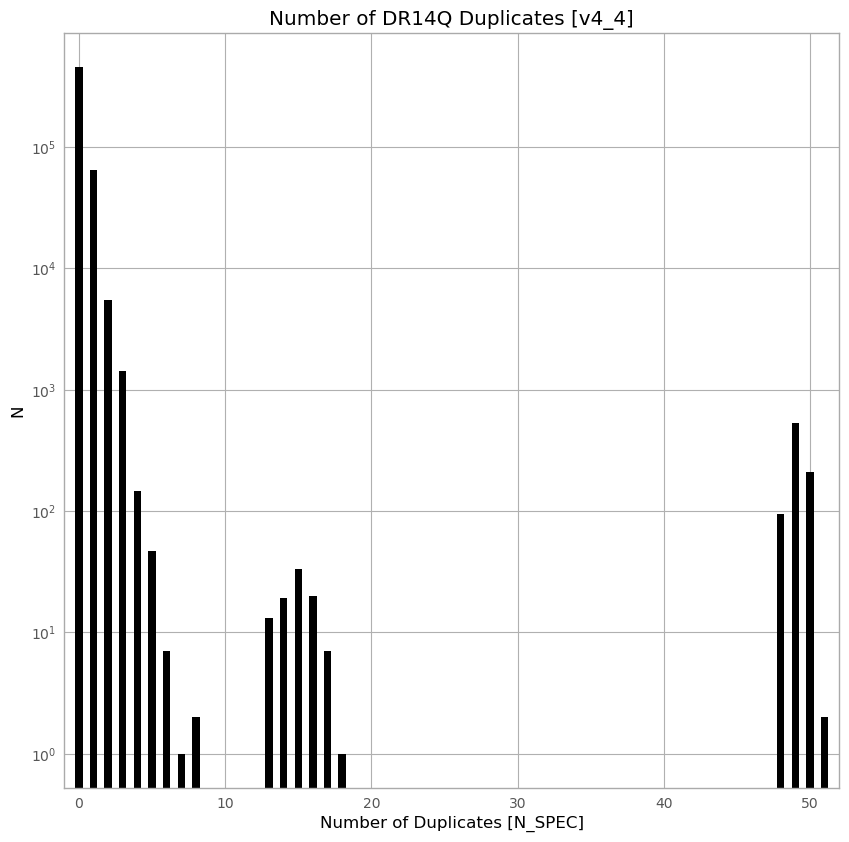

In [18]:
matplotlib.rcParams['figure.figsize'] = (10, 10)
n, x = inthist(dr14q['N_SPEC'])
w = n > 0
fig = plt.figure(dpi=100)
ax = fig.add_subplot(1, 1, 1)
b = ax.bar(x[w], n[w], align='center', width=0.5, color='k')
foo = ax.set_yscale('log')
foo = ax.set_xlim(dr14q['N_SPEC'].min()-1, dr14q['N_SPEC'].max()+1)
# foo = ax.set_ylim(0, np.ceil(np.log10(max(n))))
foo = ax.set_title('Number of DR14Q Duplicates [{0}]'.format(qso_version))
foo = ax.set_xlabel('Number of Duplicates [N_SPEC]')
foo = ax.set_ylabel('N')

In [19]:
w = dr14q['N_SPEC'] == 3
dr14q['PLATE_DUPLICATE'][w, :6]

array([[   0, 6110,    0, 6879,    0, 7595],
       [   0, 6279,    0, 6880,    0, 7663],
       [   0,  689,    0, 4220,    0, 7855],
       ...,
       [   0, 5025,    0, 5026,    0, 7581],
       [   0, 6290,    0, 6308,    0, 6588],
       [   0, 6117,    0, 6127,    0, 7598]], dtype=int32)

In [25]:
m = re.match(r'v(\d+)_(\d+)_(\d+)', boss_run2d)
N, M, P = m.groups()
br = (int(N) - 5)*10000 + int(M) * 100 + int(P)
with open('dr14q_duplicates.csv', 'w', newline='') as csvfile:
    dw = csv.writer(csvfile)
    dw.writerow(['specobjid', 'dupspecobjid', 'run2d', 'plate', 'mjd', 'fiberid', 'disk_only'])
    for k in range(len(dr14q)):
        if dr14q[k]['N_SPEC'] > 0:
            w = dr14q['PLATE_DUPLICATE'][k, :] > 0
            Nd = w.sum()
            irun2d = np.zeros((Nd,), dtype=np.uint64)
            plates = dr14q['PLATE_DUPLICATE'][k, w]
            mjds = dr14q['MJD_DUPLICATE'][k, w]
            fibers = dr14q['FIBERID_DUPLICATE'][k, w]
            for i, p in enumerate(plates):
                try:
                    foo = run2d_lookup[p]
                except KeyError:
                    q = "SELECT run2d FROM sdss_dr{0:d}_new.platex WHERE plate = {1:d} AND mjd = {2:d};".format(release, p, mjds[i])
                    try:
                        vot = qc.query(sql=q, fmt='votable', async=False)
                    except qc.queryClientError as e:
                        if str(e) == 'Error: SQL query did not return any records':
                            q = "SELECT run2d FROM sdss_dr{0:d}_new.platex WHERE plate = {1:d};".format(release, p)
                            vot = qc.query(sql=q, fmt='votable', async=False)
                        else:
                            raise
                    result = parse_single_table(BytesIO(vot.encode('utf-8')))
                    foo = run2d_lookup[p] = result.array['run2d'][0]
                if foo == boss_run2d.encode('utf-8'):
                    irun2d[i] = br
                else:
                    irun2d[i] = int(foo)
            dupspecobjid = sdss_specobjid(plates.astype(np.uint64),
                                          fibers.astype(np.uint64),
                                          mjds.astype(np.uint64) - 50000,
                                          irun2d)
            for l in range(Nd):
                dw.writerow([specobjid[k].astype(np.int64),
                             dupspecobjid[l].astype(np.int64),
                             run2d_lookup[plates[l]].decode('utf-8'),
                             plates[l],
                             mjds[l],
                             fibers[l],
                             'FALSE'])

In [21]:
galex_matched = np.zeros(specobjid.shape, dtype=np.int16)
ukidss_matched = np.zeros(specobjid.shape, dtype=np.int16)
w = np.isfinite(dr14q['GALEX_MATCHED'])
galex_matched[w] = dr14q['GALEX_MATCHED'][w].astype(np.int16)
w = np.isfinite(dr14q['UKIDSS_MATCHED'])
ukidss_matched[w] = dr14q['UKIDSS_MATCHED'][w].astype(np.int16)

In [29]:
t = Table(dr14q)
for c in dr14q.columns.names:
    if dr14q[c].dtype.type is np.float64 and c != 'RA' and c != 'DEC':
        t[c] = dr14q[c].astype(np.float32)
t['GALEX_MATCHED'] = galex_matched
t['UKIDSS_MATCHED'] = ukidss_matched
t.remove_columns(['PLATE_DUPLICATE', 'MJD_DUPLICATE', 'FIBERID_DUPLICATE', 'SPECTRO_DUPLICATE',
                  'RUN_NUMBER', 'RERUN_NUMBER', 'COL_NUMBER', 'FIELD_NUMBER', 'OBJ_ID'])
t.add_column(Column(name='SPECOBJID', data=specobjid.astype(np.character)), index=0)
t.add_column(Column(name='RUN2D', data=run2d), index=5)
t.add_column(Column(name='DISK_ONLY', data=np.zeros((len(dr14q),), dtype=np.bool)))

In [30]:
t

SPECOBJID,SDSS_NAME,RA,DEC,THING_ID,RUN2D,PLATE,MJD,FIBERID,SPECTRO,Z,Z_ERR,SOURCE_Z,Z_VI,Z_PIPE,Z_PIPE_ERR,ZWARNING,Z_PCA,Z_PCA_ER,Z_MGII,BOSS_TARGET1,ANCILLARY_TARGET1,ANCILLARY_TARGET2,EBOSS_TARGET0,EBOSS_TARGET1,EBOSS_TARGET2,N_SPEC_SDSS,N_SPEC_BOSS,N_SPEC,BI_CIV,ERR_BI_CIV,PSFFLUX [5],IVAR_PSFFLUX [5],PSFMAG [5],ERR_PSFMAG [5],MI,GAL_EXT [5],RASS_COUNTS,RASS_COUNTS_SNR,SDSS2ROSAT_SEP,FLUX_0.2_2.0keV,FLUX_0.2_2.0keV_ERR,FLUX_2.0_12.0keV,FLUX_2.0_12.0keV_ERR,FLUX_0.2_12.0keV,FLUX_0.2_12.0keV_ERR,LUM_0.2_12.0keV,SDSS2XMM_SEP,GALEX_MATCHED,FUV,FUV_IVAR,NUV,NUV_IVAR,JMAG,ERR_JMAG,JSNR,JRDFLAG,HMAG,ERR_HMAG,HSNR,HRDFLAG,KMAG,ERR_KMAG,KSNR,KRDFLAG,SDSS2MASS_SEP,W1MAG,ERR_W1MAG,W1SNR,W1CHI2,W2MAG,ERR_W2MAG,W2SNR,W2CHI2,W3MAG,ERR_W3MAG,W3SNR,W3CHI2,W4MAG,ERR_W4MAG,W4SNR,W4CHI2,CC_FLAGS,PH_FLAGS,SDSS2WISE_SEP,UKIDSS_MATCHED,YFLUX,YFLUX_ERR,JFLUX,JFLUX_ERR,HFLUX,HFLUX_ERR,KFLUX,KFLUX_ERR,FIRST_MATCHED,FIRST_FLUX,FIRST_SNR,SDSS2FIRST_SEP,DISK_ONLY
bytes20,str18,float64,float64,int32,bytes7,int16,int32,int16,str4,float32,float32,str4,float32,float32,float32,int16,float32,float32,float32,int64,int64,int64,int64,int64,int64,int16,int16,int16,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,int16,float32,float32,float32,float32,float32,float32,float32,int16,float32,float32,float32,int16,float32,float32,float32,int16,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,str4,str4,float32,int16,float32,float32,float32,float32,float32,float32,float32,float32,int16,float32,float32,float32,bool
8552380339116285952,000000.45+174625.4,0.001898274356335605,17.773739123771385,268270422,v5_10_0,7596,56945,162,BOSS,2.309,0.0,VI,2.309,2.3077507,0.0010300045,0,2.3045657,-1.0,-1.0,0,0,0,0,4096,0,0,1,1,0.0,0.0,1.0379367 .. 2.6311364,12.372533 .. 0.87061435,22.440338 .. 21.372461,0.2871244 .. 0.38545534,-24.410782,0.120217286 .. 0.035818458,0.0,0.0,-1.0,nan,nan,nan,nan,nan,nan,nan,nan,1,0.30231887,8.785573,0.7275649,4.5373588,nan,nan,nan,-1,nan,nan,nan,-1,nan,nan,nan,-1,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,,,nan,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-1,-1.0,-1.0,-1.0,False
9840556074670727168,000000.57+055630.8,0.0023754761888312714,5.941903005523435,163544156,v5_10_0,8740,57367,694,BOSS,2.1031203,0.0,AUTO,-1.0,2.1031203,0.00092415774,0,2.0996385,2.098349,2.098349,0,0,0,0,2048,0,0,0,0,0.0,0.0,1.1197296 .. 4.7301016,9.196866 .. 0.819231,22.360628 .. 20.787176,0.31018484 .. 0.24203004,-24.732,0.2338264 .. 0.069668025,0.0,0.0,-1.0,nan,nan,nan,nan,nan,nan,nan,nan,1,0.0,0.0,0.0,0.0,nan,nan,nan,-1,nan,nan,nan,-1,nan,nan,nan,-1,nan,16.969,0.127,8.5,0.9904,16.888,0.409,2.7,1.004,11.861,nan,1.4,0.9819,8.604,0.127,0.7,0.9478,hH00,BCUU,0.706171,1,1.2885137e-31,2.4790985e-32,1.2298891e-31,4.5045423e-32,1.4964246e-31,4.7290496e-32,2.459819e-31,5.689572e-32,0,-1.0,-1.0,-1.0,False
6954847382082134016,000000.66+145828.8,0.002756432550313548,14.974675485824303,244864389,v5_10_0,6177,56268,595,BOSS,2.497,0.0,VI,2.497,2.497962,0.0008690898,0,2.5099661,-1.0,-1.0,2199023255552,0,0,0,0,0,0,1,1,0.0,0.0,1.6601844 .. 5.3485007,15.4859495 .. 0.8617994,21.941969 .. 20.659208,0.16387343 .. 0.2107502,-25.664871,0.163415 .. 0.048689112,0.0,0.0,-1.0,nan,nan,nan,nan,nan,nan,nan,nan,1,0.046318613,701.1043,0.052529763,384.75098,nan,nan,nan,-1,nan,nan,nan,-1,nan,nan,nan,-1,nan,17.5,0.185,5.9,0.9299,16.206,0.211,5.2,0.8249,12.321,nan,0.3,1.149,8.51,0.185,0.7,1.036,0000,BBUU,0.495515,1,1.860383e-31,3.1476844e-32,2.3109478e-31,4.5653324e-32,2.3553143e-31,5.9704804e-32,2.4271492e-31,6.5217244e-32,0,-1.0,-1.0,-1.0,False
4970975729887977472,000000.97+044947.2,0.004052389452795069,4.829780562529699,154078229,v5_10_0,4415,55831,464,BOSS,1.619,0.0,VI,1.619,1.6172042,0.00048571048,0,1.6273098,1.6304535,1.6304535,2199023910912,0,0,0,0,0,0,0,0,0.0,0.0,6.68976 .. 19.600666,7.062735 .. 0.54124

In [31]:
t.write('dr14q_datalab.fits')

## Firefly

* [data model](https://data.sdss.org/datamodel/files/EBOSS_FIREFLY/FIREFLY_VER/sdss_eboss_firefly.html)
* The SQL file for the CAS table has units.

In [6]:
firefly_version = 'v1_0_4'
vopath = "{0}eboss/spectro/firefly/{1}/sdss_eboss_firefly-dr{2:d}.fits".format(sas, firefly_version, release)
vopath

'sdss_dr14://eboss/spectro/firefly/v1_0_4/sdss_eboss_firefly-dr14.fits'

In [7]:
with BytesIO(sc.get(vopath, mode='binary')) as q:
    with fits.open(q) as hdulist:
        f = hdulist[1].data

In [48]:
f['SPECOBJID']

299489676975171584
299489951853078528
299490501608892416
299490776486799360
299491051364706304
299491601120520192
299492150876334080
299492425754241024
299492700632147968
299492975510054912
299493525265868800


## SPIDERS

* [data model](https://data.sdss.org/datamodel/files/SPIDERS_ANALYSIS/)
* SQL file exists but does not have units, but data model does.
* Need to add `specObjID`.

In [5]:
vopath = "{0}eboss/spiders/analysis/spiders_quasar_bhmass-DR{1:d}.fits".format(sas, release)
vopath

'sdss_dr14://eboss/spiders/analysis/spiders_quasar_bhmass-DR14.fits'

In [24]:
with BytesIO(sc.get(vopath, mode='binary')) as q:
    with fits.open(q) as hdulist:
        sp = hdulist[1].data

In [35]:
specobjid = np.zeros(sp.shape, dtype=np.uint64)
w = sp['DR14_RUN2D'] == '26'
irun2d = np.zeros(sp.shape, dtype=np.uint64)
irun2d[w] = 26
w = sp['DR14_RUN2D'] == '104'
irun2d[w] = 104
w = sp['DR14_RUN2D'] == 'v5_10_0'
m = re.match(r'v(\d+)_(\d+)_(\d+)', boss_run2d)
N, M, P = m.groups()
irun2d[w] = (int(N) - 5)*10000 + int(M) * 100 + int(P)
specobjid = sdss_specobjid(sp['PLATE'].astype(np.uint64),
                           sp['FIBERID'].astype(np.uint64),
                           sp['MJD'].astype(np.uint64) - 50000,
                           irun2d)

In [36]:
w = (sp['DR14_RUN2D'] != '26') & (sp['DR14_RUN2D'] != 'v5_10_0')
sp['PLATE'][w], sp['FIBERID'][w], sp['MJD'][w], sp['DR14_RUN2D'][w]

(array([3155, 3110, 3221], dtype=int16),
 array([362, 156, 484], dtype=int16),
 array([54829, 54747, 54864], dtype=int32),
 chararray(['104', '104', '104'], dtype='<U7'))

In [37]:
w = specobjid == 6783579476627292160
# sp['PLATE'][w], sp['FIBERID'][w], sp['MJD'][w], sp['DR14_RUN2D'][w]
unwrap_specobjid(np.array([6783579476628316160], dtype=np.uint64))

rec.array([(6025, 118, 56098, 'v5_10_0', 0)],
          dtype=[('plate', '<i4'), ('fiber', '<i4'), ('mjd', '<i4'), ('run2d', '<U8'), ('line', '<i4')])

In [38]:
len(specobjid), len(np.unique(specobjid))

(8570, 7847)

In [39]:
t = Table(sp)
for c in sp.columns.names:
    # print(c, sp[c].dtype)
    if sp[c].dtype.type is np.float64 and c != 'RA' and c != 'DEC' and c != 'DR14_PLUG_RA' and c != 'DR14_PLUG_DEC':
        t[c] = sp[c].astype(np.float32)
t.add_column(Column(name='SPECOBJID', data=specobjid.astype(np.character)), index=0)


In [40]:
t

SPECOBJID,xray_detection,name,RA,DEC,ExpTime,ExiML_2RXS,DETML_XMMSL,f_2RXS,errf_2RXS,fden_2RXS,errfden_2RXS,f_XMMSL,errf_XMMSL,plate,MJD,fiberID,DR14_RUN2D,DR14_PLUG_RA,DR14_PLUG_DEC,redshift,CLASS_BEST,CONF_BEST,DR14_ZWARNING,DR14_SN_MEDIAN_ALL,norm1_mgII,errnorm1_mgII,peak1_mgII,errpeak1_mgII,width1_mgII,errwidth1_mgII,fwhm1_mgII,errfwhm1_mgII,norm2_mgII,errnorm2_mgII,peak2_mgII,errpeak2_mgII,width2_mgII,errwidth2_mgII,fwhm2_mgII,errfwhm2_mgII,norm3_mgII,errnorm3_mgII,peak3_mgII,errpeak3_mgII,width3_mgII,errwidth3_mgII,fwhm3_mgII,errfwhm3_mgII,norm_heII,errnorm_heII,peak_heII,errpeak_heII,width_heII,errwidth_heII,fwhm_heII,errfwhm_heII,norm1_hb,errnorm1_hb,peak1_hb,errpeak1_hb,width1_hb,errwidth1_hb,fwhm1_hb,errfwhm1_hb,norm2_hb,errnorm2_hb,peak2_hb,errpeak2_hb,width2_hb,errwidth2_hb,fwhm2_hb,errfwhm2_hb,norm3_hb,errnorm3_hb,peak3_hb,errpeak3_hb,width3_hb,errwidth3_hb,fwhm3_hb,errfwhm3_hb,norm4_hb,errnorm4_hb,peak4_hb,errpeak4_hb,width4_hb,errwidth4_hb,fwhm4_hb,errfwhm4_hb,norm1_OIII4959,errnorm1_OIII4959,peak1_OIII4959,errpeak1_OIII4959,width1_OIII4959,errwidth1_OIII4959,fwhm1_OIII4959,errfwhm1_OIII4959,norm2_OIII4959,errnorm2_OIII4959,peak2_OIII4959,errpeak2_OIII4959,width2_OIII4959,errwidth2_OIII4959,fwhm2_OIII4959,errfwhm2_OIII4959,norm1_OIII5007,errnorm1_OIII5007,peak1_OIII5007,errpeak1_OIII5007,width1_OIII5007,errwidth1_OIII5007,fwhm1_OIII5007,errfwhm1_OIII5007,norm2_OIII5007,errnorm2_OIII5007,peak2_OIII5007,errpeak2_OIII5007,width2_OIII5007,errwidth2_OIII5007,fwhm2_OIII5007,errfwhm2_OIII5007,norm_pl1,errnorm_pl1,slope_pl1,errslope_pl1,norm_pl2,errnorm_pl2,slope_pl2,errslope_pl2,norm_gal1,errnorm_gal1,norm_gal2,errnorm_gal2,norm_feII1,errnorm_feII1,norm_feII2,errnorm_feII2,width_feII1,errwidth_feII1,width_feII2,errwidth_feII2,r_feII,OIII_Hbeta_ratio,virialfwhm_mgII,errvirialfwhm_mgII,virialfwhm_hb,errvirialfwhm_hb,mgII_chi,hb_chi,l_2500,errl_2500,l_3000,errl_3000,l_5100,errl_5100,l_bol1,errl_bol1,l_bol2,errl_bol2,logBHMS_mgII,errlogBHMS_mgII,logBHMVP_hb,errlogBHMVP_hb,logBHMMD_hb,errlogBHMMD_hb,logBHMA_hb,errlogBHMA_hb,l_edd1,l_edd2,edd_ratio1,edd_ratio2
bytes20,str5,str23,float64,float64,float32,float32,float32,float32,float32,float32,float32,float32,float32,int16,int32,int16,str7,float64,float64,float32,str6,int16,int16,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32
4563282861596057600,2RXS,2RXS J131703.4-021538,199.26434,-2.26066,273.86,161.0,-99.0,8.035261e-12,7.752275e-13,2.8119008e-30,2.7128712e-31,-99.0,-99.0,4053,55591,38,v5_10_0,199.26423,-2.2613246,0.019339599,QSO,3,0,56.210777,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,8.338271,0.57148874,4687.37,0.20680268,2.7068005,0.2070269,26.125607,31.17999,34.60116,0.85879534,4863.0547,0.016043471,1.8879476,0.019196145,93.689026,2.7866557,12.468467,0.6284881,4858.2827,0.44450518,16.661077,0.75797975,2052.903,1

In [41]:
t.write('spiders_quasar_bhmass_datalab.fits')


## Redmonster

* [data model](https://data.sdss.org/datamodel/files/REDMONSTER_SPECTRO_REDUX/RUN2D/REDMONSTER_VER/redmonsterAll.html)
* 64-bit targeting flags are stored as 32-bit integers.  Oops.  Just drop them.
* Huh, there aren't very many plates in redmonsterAll.

In [5]:
redmonster_version = 'v1_2_0'
vopath = "{0}eboss/spectro/redux/redmonster/{1}/{2}/redmonsterAll-{1}.fits".format(sas, boss_run2d, redmonster_version)
vopath

'sdss_dr14://eboss/spectro/redux/redmonster/v5_10_0/v1_2_0/redmonsterAll-v5_10_0.fits'

In [33]:
with BytesIO(sc.get(vopath, mode='binary')) as q:
    with fits.open(q) as hdulist:
        rm = hdulist[1].data

In [41]:
rm['PLATE'].max()

10000